In [93]:
import struct as st
import numpy as np
import matplotlib.pyplot as plt
import sys

In [94]:
def unpack_data(data_file):
    image_file = open(data_file['images'],'rb')
    image_file.seek(0)

    st.unpack('>4B',image_file.read(4))
    num_images = st.unpack('>I',image_file.read(4))[0]
    
    num_rows = 0
    num_cols = 0
    
    num_rows = st.unpack('>I',image_file.read(4))[0]
    num_cols = st.unpack('>I',image_file.read(4))[0]

    label_file = open(data_file['labels'],'rb')
    label_file.seek(0)

    st.unpack('>4B',label_file.read(4))
    num_labels = st.unpack('>I',label_file.read(4))[0]

    if(num_images != num_labels):
        print("Number of images and labels in the datado not match, terminating neural network training")
        sys.exit(1)

    num_bytes_total = num_images*num_rows*num_cols*1
    images_array = np.asarray(st.unpack('>'+'B'*num_bytes_total,image_file.read(num_bytes_total))).reshape((num_images,num_rows,num_cols))

    training_labels = np.zeros((num_labels,digits,1),dtype=np.int32)

    for i in range(0, num_labels):
        label_value = st.unpack('>B',label_file.read(1))
        training_labels[i,label_value] = 1
    
    return images_array, training_labels, num_rows, num_cols, num_images

In [95]:
def step_activation_function(induced_local_field):
    """
    Activation function (Step function)
    """
    return 1 if induced_local_field >=0 else 0

vec_act_func = np.vectorize(step_activation_function)

In [96]:
def plot_epoch_vs_misclassifications(epoch_error, training_size, learning_rate):
    """
    Plot Misclassifications vs Epoch
    """
    plt.figure(figsize=(11,6))
    plt.xlabel('Epochs')
    plt.ylabel('Misclassifications')
    plt.title(f"Epochs vs Misclassifications\nTraining Size: {training_size}\nLearning Rate: {learning_rate}")
    plt.plot(range(len(epoch_error)), epoch_error)
    plt.show()

In [97]:
def perceptron_training_algorithm(isTrain, weights, training_size, learning_rate, misclassification_epoch_ratio, image_array, labels, num_rows, num_cols):

    epoch = 0
    epoch_error = []
    
    while(True):
        epoch_error.append(0)
        for i in range(0, training_size):
            input_vector = image_array[i].reshape(num_rows*num_cols,1)
            induced_local_field_array = np.dot(weights, input_vector)
            output_array = vec_act_func(induced_local_field_array)
            desired_output = labels[i]
            
            if(np.argmax(induced_local_field_array) != np.argmax(desired_output)):
                epoch_error[epoch]+=1
            
            if(isTrain):
                # Update weights
                weights = weights + learning_rate * (desired_output - output_array) *  input_vector.reshape(1,-1)
        
        if(isTrain):
            epoch+=1
            if(epoch_error[epoch-1] / training_size <= misclassification_epoch_ratio):
                print(f"Model converged after {epoch -1} epochs")
                break
            elif(epoch>=epoch_limit):
                print(f"Stopping training of the model as it did not converge even after {epoch}th epoch.")
                break
        else:
            accuracy = (training_size-epoch_error[0]) * 100.0 / training_size
            return epoch_error
     
    return weights, epoch_error

In [102]:
training_filename = {'images' : 'train-images.idx3-ubyte' ,'labels' : 'train-labels.idx1-ubyte'}
testing_filename = {'images' : 't10k-images.idx3-ubyte' ,'labels' : 't10k-labels.idx1-ubyte'}

# Unpack Training and testing Data
training_image_array, training_labels, num_images_rows_training, num_images_cols_training, num_training_images = unpack_data(training_filename)
testing_image_array, testing_labels, num_images_rows_testing, num_images_cols_testing, num_testing_images = unpack_data(testing_filename)

digits=10

learning_rate = 1
misclassification_epoch_ratio = 0
initial_weights = np.array(np.random.uniform(low=-1, high=1, size=(digits*num_images_rows_training*num_images_cols_training))).reshape((digits, num_images_rows_training*num_images_cols_training))

epoch_limit = 50

### Training a model with a training size of 50, learning rate of 1 and epsilon of 0.


Training model with 50 data samples, learning rate 1 and epsilon 0
Model converged after 4 epochs


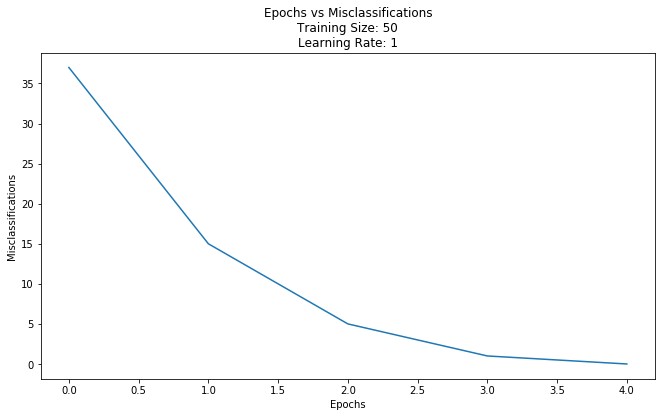

0.0% misclassification in training data
43.72%  misclassification in test data


In [103]:
training_size = 50

print(f"Training model with {training_size} data samples, learning rate {learning_rate} and epsilon {misclassification_epoch_ratio}")
weights, training_epoch_error = perceptron_training_algorithm(True, np.copy(initial_weights), training_size, learning_rate, misclassification_epoch_ratio, training_image_array, training_labels, num_images_rows_training, num_images_cols_training)
plot_epoch_vs_misclassifications(training_epoch_error, training_size, learning_rate)
print(f"{100.0 * training_epoch_error[-1] / training_size}% misclassification in training data")

testing_epoch_error = perceptron_training_algorithm(False, weights, num_testing_images, learning_rate, misclassification_epoch_ratio, testing_image_array, testing_labels, num_images_rows_testing, num_images_cols_testing)
print(f"{100.0 * testing_epoch_error[0] / num_testing_images}%  misclassification in test data")

### Analysis

#### The training of the model with the training data (size=50) ended with a 0% misclassification and the test data had a 43.72% misclassification. The training data size is very low compared to the testing data size and hence the low accuracy on test data compared to training data accuracy. The parameters are not trained well with such a small training size.

## Training a model with a training size of 1000, learning rate of 1 and epsilon of 0.

Training model with 1000 data samples, learning rate 1 and epsilon 0
Model converged after 33 epochs


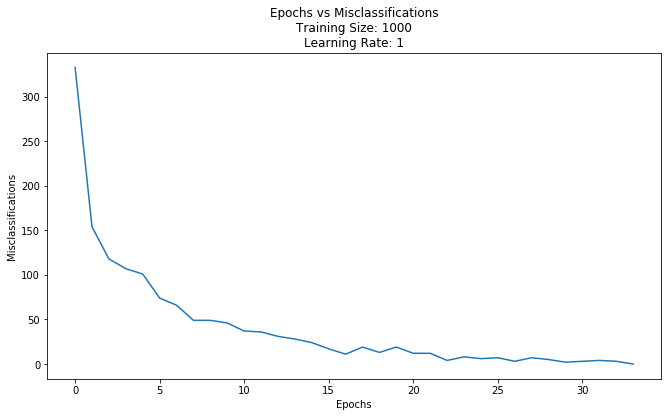

0.0% misclassification in training data
17.28%  misclassification in test data


In [104]:
training_size = 1000

print(f"Training model with {training_size} data samples, learning rate {learning_rate} and epsilon {misclassification_epoch_ratio}")
weights, training_epoch_error = perceptron_training_algorithm(True, np.copy(initial_weights), training_size, learning_rate, misclassification_epoch_ratio, training_image_array, training_labels, num_images_rows_training, num_images_cols_training)
plot_epoch_vs_misclassifications(training_epoch_error, training_size, learning_rate)
print(f"{100.0 * training_epoch_error[-1] / training_size}% misclassification in training data")

testing_epoch_error = perceptron_training_algorithm(False, weights, num_testing_images, learning_rate, misclassification_epoch_ratio, testing_image_array, testing_labels, num_images_rows_testing, num_images_cols_testing)
print(f"{100.0 * testing_epoch_error[0] / num_testing_images}%  misclassification in test data")

### Analysis

#### The training of the model with the training data (size=1000) ended with a 0% misclassification and the test data had a 17.28% misclassification. Compared to the previous training, this has a bigger size of data and hence the relatively higher accuracy (or lower misclassifications). Though the training data size is still much lower than the testing data size and hence the low accuracy on test data compared to training data accuracy. The parameters are not trained well with such a small training size.

### Training a model with a training size of 60000, learning rate of 1 and epsilon of 0.

Training model with 60000 data samples, learning rate 1 and epsilon 0
Stopping training of the model as it did not converge even after 50th epoch.


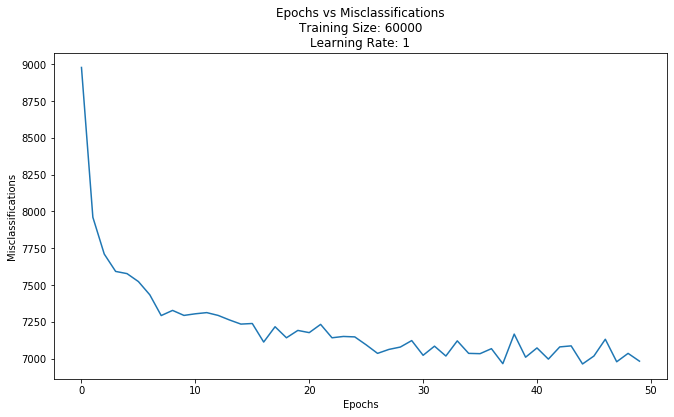

11.636666666666667% misclassification in training data
16.22%  misclassification in test data


In [105]:
training_size = 60000

print(f"Training model with {training_size} data samples, learning rate {learning_rate} and epsilon {misclassification_epoch_ratio}")
weights, training_epoch_error = perceptron_training_algorithm(True, np.copy(initial_weights), training_size, learning_rate, misclassification_epoch_ratio, training_image_array, training_labels, num_images_rows_training, num_images_cols_training)
plot_epoch_vs_misclassifications(training_epoch_error, training_size, learning_rate)
print(f"{100.0 * training_epoch_error[-1] / training_size}% misclassification in training data")

testing_epoch_error = perceptron_training_algorithm(False, weights, num_testing_images, learning_rate, misclassification_epoch_ratio, testing_image_array, testing_labels, num_images_rows_testing, num_images_cols_testing)
print(f"{100.0 * testing_epoch_error[0] / num_testing_images}%  misclassification in test data")

### Analysis

#### The training of the model with the training data (size=60000) was stopped with a 11.64% misclassification and the test data had a 16.22% misclassification. Here the training did not converge, but was stopped after 50 epochs. The accuracy increased by a small percentage compared to the previous trainings. The difference between the training data accuracy and test data accuacy is not very significant as the model has had a big data set to train with and has reached a threshold.

## Training a model with a training size of 60000, learning rate of 1 and epsilon of 0.12 (3 trials).

Iteration 1:
Training model with 60000 data samples, learning rate 1 and epsilon 0.12
Model converged after 14 epochs


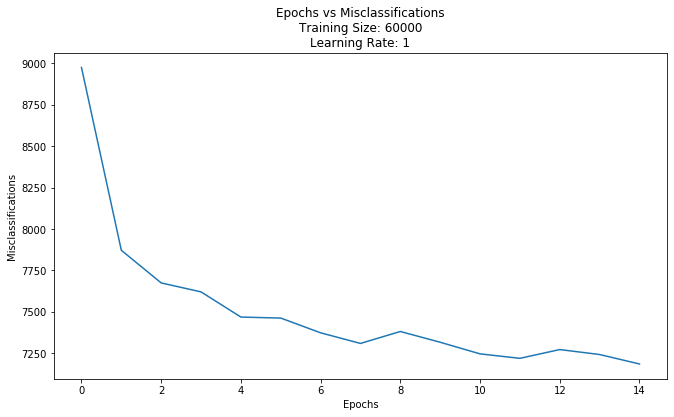

11.976666666666667% misclassification in training data
17.46%  misclassification in test data

Iteration 2:
Training model with 60000 data samples, learning rate 1 and epsilon 0.12
Model converged after 15 epochs


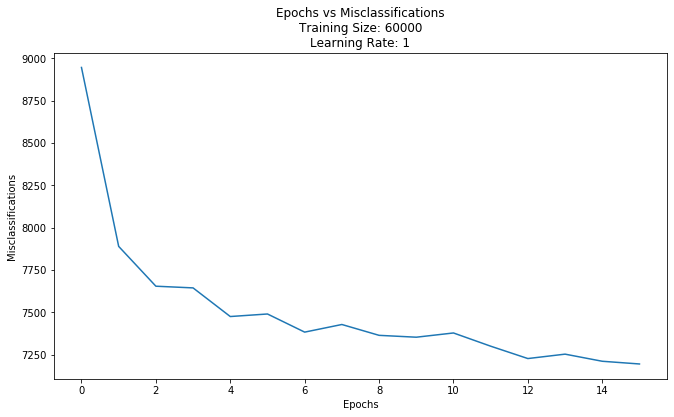

11.991666666666667% misclassification in training data
16.61%  misclassification in test data

Iteration 3:
Training model with 60000 data samples, learning rate 1 and epsilon 0.12
Model converged after 13 epochs


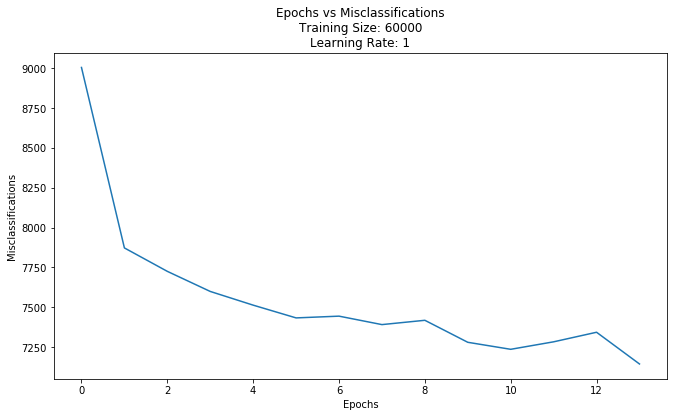

11.906666666666666% misclassification in training data
13.92%  misclassification in test data



In [109]:
training_size = 60000
misclassification_epoch_ratio = 0.12
learning_rate = 1

for i in range (0,3):
    print(f"Iteration {i+1}:")
    initial_weights = np.array(np.random.uniform(low=-1, high=1, size=(digits*num_images_rows_training*num_images_cols_training))).reshape((digits, num_images_rows_training*num_images_cols_training))

    print(f"Training model with {training_size} data samples, learning rate {learning_rate} and epsilon {misclassification_epoch_ratio}")
    weights, training_epoch_error = perceptron_training_algorithm(True, initial_weights, training_size, learning_rate, misclassification_epoch_ratio, training_image_array, training_labels, num_images_rows_training, num_images_cols_training)
    plot_epoch_vs_misclassifications(training_epoch_error, training_size, learning_rate)
    print(f"{100.0 * training_epoch_error[-1] / training_size}% misclassification in training data")

    testing_epoch_error = perceptron_training_algorithm(False, weights, num_testing_images, learning_rate, misclassification_epoch_ratio, testing_image_array, testing_labels, num_images_rows_testing, num_images_cols_testing)
    print(f"{100.0 * testing_epoch_error[0] / num_testing_images}%  misclassification in test data")
    print()

### Analysis

#### The leraning rate is kept at ***1*** as it seems like a reasonable value by looking at the 3 initial trainings, where the number of misclassification decreased quickly with the same learning rate

### The epsilon is kept at ***12% (0.12)*** as observed from the previous training (with size 60000). There the lowest misclassification was an average of 12% as observed from th plot.

### Training size is 60000, and Testing size is 10000.

### The three Training (Iterations) with different initial_weights render similar results with 17.46%, 16.61% and 13.92% misclassification respectively on test data and 11.98%, 11.99%, and 11.91% misclassification on training data. The model training did converge as the epsilon was kept at 0.12. They converged after 14, 15 and 13 epochs respectively. It can be observed that a reatively good accuracy is obtained pretty early and then the model just oscillates at that accuracy during training and does not converge.